---
## Exploratory data analsysis

In [1]:
import pandas as pd, matplotlib.pyplot as plt

c:\Users\luisr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Reload data

In [9]:
data_path = '../Dados'
control_path = f'{data_path}/blobs/videos_control_19-04.csv'

control = pd.read_csv(control_path)
control['timestamp'] = pd.to_datetime(control['timestamp'])

#### Cameras alerady recorded

In [10]:
print('Cameras recorded:', control['code'].nunique())

Cameras recorded: 2426


#### Folder structure count

In [11]:
control[['n_folders', 'folder_structure']].value_counts().sort_index()

n_folders  folder_structure                         
3          {type}/{code}                                21182
4          polygons/{type}/{code}                          69
           {type}/{subtype}/{code}                        476
5          polygons/{type}/{polygon}/{code}             11187
           {source}/{type}/{event}/{code}                9914
6          polygons/{source}/{type}/{polygon}/{code}      462
Name: count, dtype: int64

### Videos over time

In [13]:
ts = control.set_index('timestamp')
time_cnt = control.groupby('timestamp').count()['blob_name']
time_size_cnt = control.groupby('timestamp')['blob_size'].sum()

#### Event types count

In [14]:
def event_info(blob_name):
    "returns event type and event id given `blob_name` matching the folder structure `{source}/{type}/{event}/{code}`."
    info = blob_name.split('/')
    return ['/'.join(info[:2]), info[2]]

folder_structure_msk = ts['folder_structure'] =='{source}/{type}/{event}/{code}'
event_cnt = ts[folder_structure_msk]['blob_name'].apply(event_info).tolist()
event_cnt = pd.DataFrame(event_cnt, columns=['event_type', 'event_id'])

event_type_cnt = event_cnt.drop_duplicates()['event_type'].value_counts()

print(f'\n{event_type_cnt}\n')


event_type
waze/flood            568
comando/bolsão         47
comando/alagamento      7
comando/lâmina          5
rivers/manual           2
Name: count, dtype: int64



#### Videos per day and cumulative

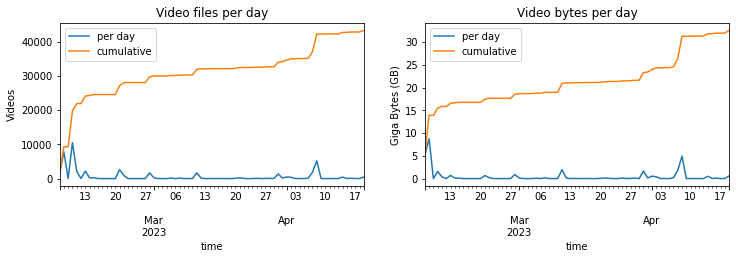

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

time_cnt.resample('1D').sum().plot(ax=axs[0])
time_cnt.resample('1D').sum().cumsum().plot(ax=axs[0])
axs[0].set(title='Video files per day', ylabel='Videos', xlabel='time')
axs[0].legend(['per day', 'cumulative'])

(time_size_cnt.resample('1D').sum() / 1e9).plot(ax=axs[1])
(time_size_cnt.resample('1D').sum().cumsum() / 1e9).plot(ax=axs[1])
axs[1].set(title='Video bytes per day', ylabel='Giga Bytes (GB)', xlabel='time')
axs[1].legend(['per day', 'cumulative'])
plt.show()

#### Videos per camera

In [16]:
print(f'Videos per camera:\n\n{control["code"].value_counts().head(10)}')

Videos per camera:

code
1487    529
278     526
3323    438
1635    254
1636    251
1639    250
1462    250
1638    243
262     220
1649    214
Name: count, dtype: int64


#### Bytes per câmera

In [17]:
print(f'Total MB per câmera:\n\n{control.groupby("code")["blob_size"].sum().sort_values(ascending=False) / 1e6}')

Total MB per câmera:

code
278     996.349552
1487    492.780141
482     406.056572
3323    380.590463
267     375.663969
           ...    
2272      0.016630
146       0.016618
2271      0.016520
422       0.016491
1025      0.015996
Name: blob_size, Length: 2426, dtype: float64


### Recently recorded

#### Past 30 days

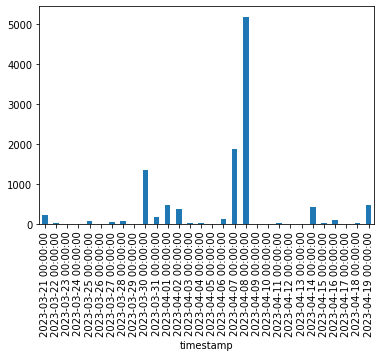

In [21]:
days = 30

ax = ts['blob_name'].resample('1D').count().tail(days).plot.bar()

### Recently recorded per type

In [22]:
type_control = pd.DataFrame(index=ts.index)

types = ['waze/flood', 'comando/bolsão', 'comando/alagamento']

for subtype in types:
    type_control[subtype] = ts['blob_name'].str.startswith(subtype)

#### Video per type count

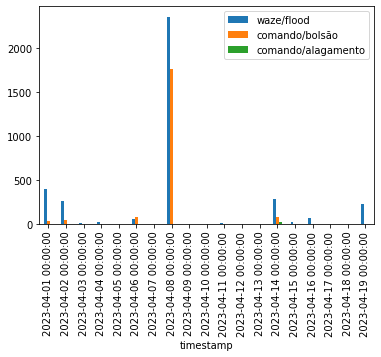

In [23]:
freq = '1D'
start_date = '2023-04-01'

types_cnt = []
for subtype in types:
    types_cnt.append(ts['blob_name'][type_control[subtype]].resample(freq).count()[start_date:].rename(subtype))

types_cnt = pd.concat(types_cnt, axis=1).fillna(0.0)

ax = types_cnt.plot.bar()